# Ensemble Learning and Random Forests

集成学习利用群体的智慧$(wisdom\ of\ the\ crowd)$,集合一组估计器的预测， 通常会得到比个体估计更优的结果    
流行的集成学习方法有$bagging,\ boosting,\ stacking$  
集成学习的精度，所有的基预测器都应该是独立的，产生不相关的错误，这样才不会在相同的错误上投很多票，一般来说我们用不同的算法来产生不同类型的误差，避免因此降低集成学习的精度。

In [2]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from matplotlib.pylab import plt
from sklearn.model_selection import train_test_split
import matplotlib as plb
import numpy as np
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^')
    plt.grid(True, which='both')

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plot_dataset(X_test, y_test)

In [3]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap) 
    if(contour):
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)# 画出决策边界
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.grid(True, which='both')

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

此处使用的是硬($hard$)投票，采取多数票   
如果换成软($soft$)投票按照每个基模型的$proba$输出最自信的分类,一般来说采取软投票得到的结果更优

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.888
VotingClassifier 0.896


/Users/hu-osx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Bagging and Pasting

In [6]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
print(accuracy_score(y_test,tree_clf.predict(X_test)))

0.856


In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500, max_samples=100, 
        bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


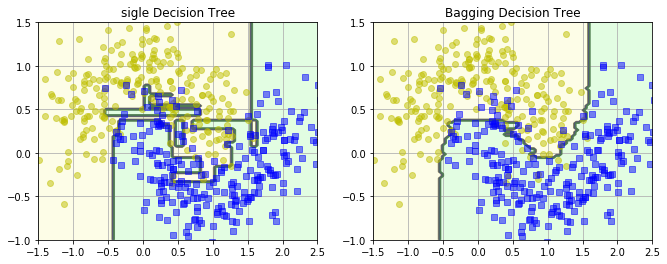

In [8]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.title(r'sigle Decision Tree')
plot_decision_boundary(tree_clf, X, y)
plt.subplot(122)
plt.title(r'Bagging Decision Tree')
plot_decision_boundary(bag_clf, X, y)
plt.show()

# Out-of-Bag Evaluation

有放回采样有37%的数据不能被采样到， 所以我们可以拿他们做验证集，这些(out-of-bag)oob可以通过设置oob_score=True,开启

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    bootstrap=True, n_jobs=-1, max_samples=100,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
print('训练集精确度：', accuracy_score(y_train, bag_clf.predict(X_train)))
print('验证集精确度：', bag_clf.oob_score_)
print('测试集精确度：', accuracy_score(y_test, bag_clf.predict(X_test)))
print(bag_clf.oob_decision_function_) # 返回每个基估计器的决策分数

训练集精确度： 0.9386666666666666
验证集精确度： 0.928
测试集精确度： 0.912
[[0.35449735 0.64550265]
 [0.33862434 0.66137566]
 [1.         0.        ]
 [0.015      0.985     ]
 [0.03875969 0.96124031]
 [0.09873418 0.90126582]
 [0.41961853 0.58038147]
 [0.06565657 0.93434343]
 [0.94414894 0.05585106]
 [0.864      0.136     ]
 [0.56185567 0.43814433]
 [0.04738155 0.95261845]
 [0.68146214 0.31853786]
 [0.8778626  0.1221374 ]
 [0.91066998 0.08933002]
 [0.10913706 0.89086294]
 [0.01827676 0.98172324]
 [0.93877551 0.06122449]
 [0.65482234 0.34517766]
 [0.96808511 0.03191489]
 [0.05154639 0.94845361]
 [0.2475     0.7525    ]
 [0.86901763 0.13098237]
 [0.99210526 0.00789474]
 [0.96418733 0.03581267]
 [0.0026455  0.9973545 ]
 [0.95844156 0.04155844]
 [1.         0.        ]
 [0.01036269 0.98963731]
 [0.6870229  0.3129771 ]
 [0.         1.        ]
 [1.         0.        ]
 [0.00518135 0.99481865]
 [0.06266319 0.93733681]
 [0.1125     0.8875    ]
 [0.97680412 0.02319588]
 [0.01866667 0.98133333]
 [0.54005168 0.45994

# Random Patches and Random Subpaces

前者采样数据和特征， 后者只采样特征或数据   
`bootstrap=False, max_samples=1.0`      
`bootstrap_features=True, max_features<1.0`

# Random Forests

In [10]:
# 直接使用ensemble集成随机森林，决策树和bagging相结合，有些参数被强制比如max_samples=1.0
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                 n_jobs=-1)
rnd_clf.fit(X_train, y_train)
accuracy_score(y_test, rnd_clf.predict(X_test))

0.912

In [11]:
# 使用bagging集合基估计器，可以添加splitter='random', 
# 这样在划分节点时不必在所有特征上搜索得到最好的特征，
# 而是使用特征子集， 也是一种牺牲偏差，降低了方差，总体上将取得更好的随机森林
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, bootstrap=True, max_samples=1.0
)
bag_clf.fit(X_train, y_train)
accuracy_score(y_test, bag_clf.predict(X_test))

0.904

# Extra-Tree
随机阈值选择最优特征

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
ex_rnd_clf = ExtraTreesClassifier(n_estimators=500, bootstrap=True, 
                                  n_jobs=-1, max_leaf_nodes=16)
ex_rnd_clf.fit(X_train, y_train)
accuracy_score(y_test, ex_rnd_clf.predict(X_test))

0.912

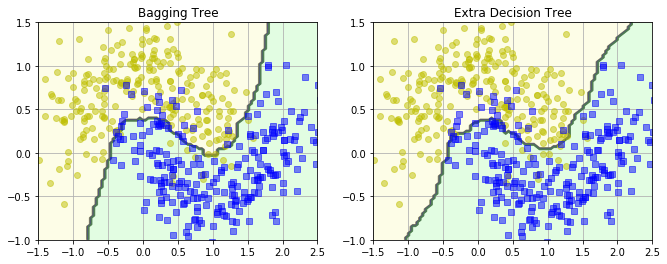

In [13]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.title(r'Bagging Tree')
plot_decision_boundary(bag_clf, X, y)
plt.subplot(122)
plt.title(r'Extra Decision Tree')
plot_decision_boundary(ex_rnd_clf, X, y)
plt.show()

# Feature Importance

使用随机森林可以很直观的看出哪些特征在决策中起到重要作用，只需计算出特征节点的深度

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)
print(rnd_clf.feature_importances_)

sepal length (cm) 0.09119635780374323
sepal width (cm) 0.022827333519515755
petal length (cm) 0.4670329901593941
petal width (cm) 0.4189433185173469
[0.09119636 0.02282733 0.46703299 0.41894332]


In [15]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

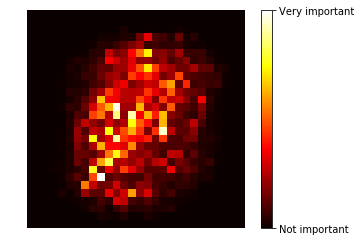

In [16]:
def plot_digit(date):
    img = date.reshape(28, 28)
    plt.imshow(img, cmap=plb.cm.hot, interpolation='nearest')
    plt.axis('off')
    
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), 
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()
# 可见手写体边界部分不那么重要，我们可以利用此来降维

# Boosting

## AdaBoost

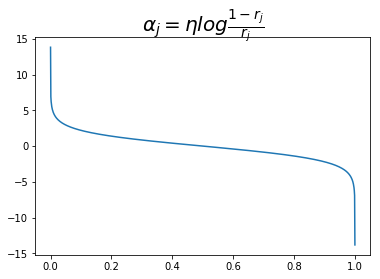

In [3]:
import numpy as np
X = np.linspace(0.000001,1-0.000001,1000)
y = np.log((1-X)/X)
plt.plot(X,y)
plt.title(r'$\alpha_j=\eta log\frac{1-r_j}{r_j}$', fontsize=20)
plt.show()

#### adaboost更新样例权重过程：  
初始化每个instance权重为$\frac{1}{m}$, 
对于第一个预测器定义其权重错误率为$\displaystyle r_j={{\sum_{i=1}^m}1(\hat{y}_j^{(i)}\neq y^{(i)})w^{(i)}}\div {\sum_{i=i}^mw^{(i)}}$

预测器的权重通过$r_j$来更新，将$r_j$带入$\alpha_j=\eta log\frac{1-r_j}{r_j}$进而得到每个预测器的权重   
有了这次预测的权重，用其来更新instance的权重，策略是预测错的提高权重，预测对的保持权重，即有：   
$w^{(i)}\leftarrow \begin{cases}
 w^{(i)}& \text{ if } \hat{y_j}^{(i)}=y^{(i)} \\ 
 w^{(i)}\cdot e^{\alpha_j}& \text{ if } \hat{y_j}^{(i)}\neq y^{(i)} 
\end{cases}$$\ \ for\ i=1,2,...,m$   

在本轮更新后，除以$\sum_{i=1}^mw^{(i)}$来normalize

##### 预测时AdaBoost计算每个预测器的预测及其权重，取多数决策    
$\displaystyle \hat{y}(x)=\underset{k}{\mathrm{argmax}}\sum_{j=1}^{N}1(\hat{y}_j(x)=k)\alpha_j$, $N$是预测器的个数

*sklearn* 使用多标签版本的*AdaBoost*称为$SAMME(Stagewise\ Additive\ Modeling\ using\ a\ Multiclass\ Exponential\ loss\ function)$   
当只有两个class时，SAMME等同于AdaBoost，如果每个基预测器都有`predict_proba()`方法，    
其预测将采用class的probabilities, 在sklearn中使用SAMME的变体SAMME.R

In [4]:
from sklearn.ensemble import AdaBoostClassifier

ada_with_SAMME_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME", learning_rate=0.5
)

ada_with_SAMME_R_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5
)
ada_with_SAMME_R_clf.fit(X_train,y_train)
ada_with_SAMME_clf.fit(X_train, y_train)
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title('SAMME')
plot_decision_boundary(ada_with_SAMME_clf, X_train, y_train)
plt.subplot(122)
plt.title('SAMME.R')
plot_decision_boundary(ada_with_SAMME_R_clf, X_train, y_train)
plt.show()

NameError: name 'DecisionTreeClassifier' is not defined

## Gradient Boosting

通过计算残差误差($residual\ error$)累加模型结果   
决策树的Gradient Boosting称为$GBRT(Gradient\ Boosted\ Regression\ Tree)$或$GTB(Gradient\ Tree\ Boosting)$   
以下以拟合二次曲线为例  

In [58]:
def plot_decision(models, X, y, axes, label=None, style='r-', data_style='b.',data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(model.predict(x1.reshape(-1, 1)) for model in models)
    plt.plot(X[:, 0], y, data_style, label=label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

In [59]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X.reshape(-1)**2 + 0.05 * np.random.randn(100)
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [60]:
y2 = y - tree_reg1.predict(X) # 算一次残差
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [61]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [62]:
X_new = np.array([[-0.3]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(3*X_new.reshape(-1)**2+ 0.05*np.random.rand(1), y_pred)

[0.30225517] [0.29044761]


In [63]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)
print(3*X_new.reshape(-1)**2+ 0.05*np.random.rand(1), gbrt.predict(X_new))

[0.27976215] [0.29044761]


accumulative error 0.0033352865488483546
Early stopping     0.002489087838004434 33 trees


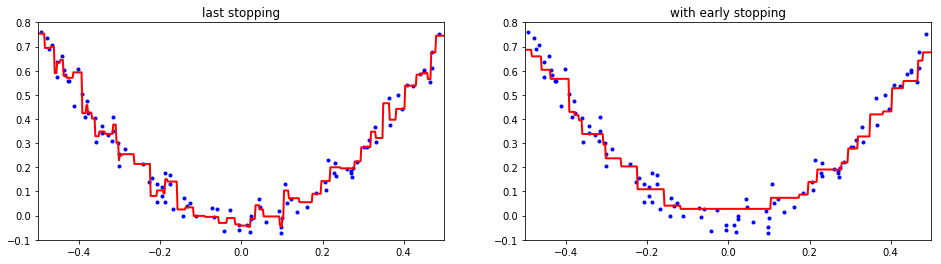

In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_val,y_train, y_val =  train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200)
gbrt.fit(X_train, y_train)
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title('last stopping')
plot_decision([gbrt], X, y, [-0.5, 0.5, -0.1, 0.8])
print('accumulative error', mean_squared_error(y_val, gbrt.predict(X_val)))
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)
gbrt_bst = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_bst.fit(X_train, y_train)
print('Early stopping    ', mean_squared_error(y_val, gbrt_bst.predict(X_val)), bst_n_estimators, 'trees')
plt.subplot(122)
plt.title('with early stopping')
plot_decision([gbrt_bst], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.show()

[]

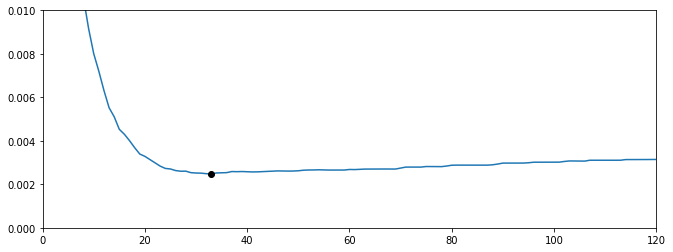

In [65]:
plt.figure(figsize=(11, 4))
plt.plot(errors)
plt.axis([0, 120, 0, 0.01])
min_error = np.min(errors)
plt.plot(bst_n_estimators,min_error,"ko")
plt.plot()

##### 子采样， 即在每一次更新gradient时， 随机采样,  仍然是提高了泛化能力 
gradient boosting还支持更该loss function

0.0023801132234954076


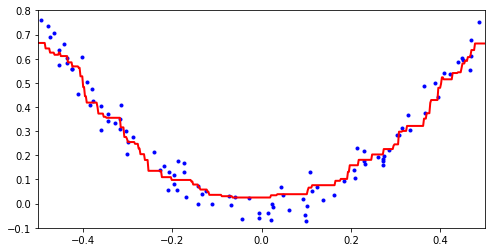

In [66]:
stochastic_gbrt = GradientBoostingRegressor(n_estimators=bst_n_estimators, subsample=0.25, max_depth=2)# 随机采样
stochastic_gbrt.fit(X_train, y_train)
print(mean_squared_error(y_val, stochastic_gbrt.predict(X_val)))
plt.figure(figsize=(8, 4))
plot_decision([stochastic_gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.show()

## Stacking
$\mathrm{stacked\ generalization}$ 各预测器的结果传给bleander或元学习器

将训练集划分成子训练集1，子训练集2$(held-out)$， 利用子集1训练出几个基预测器，    
将子集2作为新数据送给若干基预测器，将其输出的结果作为新的特征，再训练出blender,           
这样每次每次遇到新数据时，我们可以combine各个预测器的结果放入blender中输出     
同时为了增加堆叠的效果，我们还可以将数据集分为3个子集， 第一个子集训练出基预测器（layer1），基预测器根据第二个子集预测出结果，将结果作为新的维度特征训练出不同的子blender(layer2), 子集3传入layer1，和layer2,训练出Blender(Layer3)

### 使用xgboost实现堆叠训练

In [67]:
from sklearn.metrics import mean_squared_error
try:
    import xgboost
except ImportError as ex:
    print("xgboost not installed!")
    xgboost=None

In [68]:
if xgboost is not None:
    xgb_clf = xgboost.XGBRegressor(random_state=42)
    xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_clf.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print('val MSE error:', val_error)

[0]	validation_0-rmse:0.294637
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.265151
[2]	validation_0-rmse:0.238242
[3]	validation_0-rmse:0.214206
[4]	validation_0-rmse:0.192894
[5]	validation_0-rmse:0.173567
[6]	validation_0-rmse:0.158134
[7]	validation_0-rmse:0.144335
[8]	validation_0-rmse:0.132051
[9]	validation_0-rmse:0.120021
[10]	validation_0-rmse:0.110671
[11]	validation_0-rmse:0.102506
[12]	validation_0-rmse:0.095114
[13]	validation_0-rmse:0.088876
[14]	validation_0-rmse:0.08204
[15]	validation_0-rmse:0.077335
[16]	validation_0-rmse:0.073199
[17]	validation_0-rmse:0.069934
[18]	validation_0-rmse:0.067289
[19]	validation_0-rmse:0.064565
[20]	validation_0-rmse:0.061817
[21]	validation_0-rmse:0.060342
[22]	validation_0-rmse:0.058153
[23]	validation_0-rmse:0.056686
[24]	validation_0-rmse:0.055484
[25]	validation_0-rmse:0.054612
[26]	validation_0-rmse:0.05388
[27]	validation_0-rmse:0.053632
[28]	validation_0-rmse:0.0533
[29]	validation_0-rmse

##### Exercise 8

In [69]:
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier

mnist = fetch_mldata("MNIST original")
X = mnist['data']
y = mnist['target']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

rnf = RandomForestClassifier(n_jobs=-1)
svm = LinearSVC()
ex_tree = ExtraTreesClassifier(n_jobs=-1)
mlp_clf = MLPClassifier()

estimators = [rnf, svm, ex_tree, mlp_clf]
for estimator in estimators:
    estimator.fit(X_train, y_train)
    print(estimator)
    
[estimator.score(X_val, y_val) for estimator in estimators] # 使用模型score属性计算精确度


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_

[0.9453, 0.8715, 0.9498, 0.9499]

In [105]:
volting_clf = VotingClassifier( # 集成学习
    estimators=[ ('rnf', rnf), ('svm', svm),
    ('ex_tree', ex_tree), ('mlp_clf', mlp_clf)]
)
volting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rnf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_w...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [106]:
print(volting_clf.score(X_val, y_val)) # 集成学习的精确度
print([estimator.score(X_val, y_val) for estimator in volting_clf.estimators_]) # 个体的精确度

/Users/hu-osx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.961
[0.9475, 0.8403, 0.9497, 0.9547]


In [72]:
# 考虑到SVM十分突出，我们看一下他到底是帮助了模型决策还是带偏了模型
volting_clf.set_params(svm=None) # 看不到QAQ

VotingClassifier(estimators=[('rnf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_w...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [73]:
volting_clf.estimators

[('rnf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)),
 ('svm', None),
 ('ex_tree',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0, warm_start=False)),
 ('mlp_clf',
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
         beta

In [74]:
volting_clf.estimators_ # 然而设置为None,estimators_删不掉, 输出estimators为元祖，输出estimators_为模型

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_s

In [75]:
# 让我们直接从volting中删了SVM
del volting_clf.estimators_[1]

In [76]:
volting_clf.estimators_# 现在删掉了

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_

In [77]:
volting_clf.score(X_val, y_val) #现在看来SVM确实带偏了模型

/Users/hu-osx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9659

In [78]:
# 我们看看用soft投票是否会改善模型
volting_clf.voting = "soft"

In [79]:
volting_clf.score(X_val, y_val) # 所以说按概率输出更能令人信服，相当于专家决策一般？

/Users/hu-osx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9672

In [80]:
volting_clf.score(X_test, y_test) # not bad

/Users/hu-osx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.967

In [81]:
[estimator.score(X_val, y_val) for estimator in volting_clf.estimators_]

[0.9489, 0.9496, 0.9556]

# Exercise 9
根据作业8，创建stacking堆叠模型

In [102]:
# 训练集划分成三个子集X_train, X_val, X_test
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32) # layer2
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
X_val_predictions , X_val_predictions.shape# layer2 input

(array([[2., 2., 2., 2.],
        [7., 7., 7., 7.],
        [4., 4., 4., 4.],
        ...,
        [4., 4., 4., 4.],
        [9., 9., 9., 9.],
        [4., 4., 4., 4.]], dtype=float32), (10000, 4))

In [103]:
y_val.shape

(10000,)

In [95]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42) # layer2 只有一个Blender
rnd_forest_blender.fit(X_val_predictions, y_val) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [96]:
rnd_forest_blender.oob_score_

0.9584

In [101]:
X_test_prections = np.empty((len(X_val_predictions), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_test_prections[:, index] = estimator.predict(X_test)
X_test_prections, X_test_prections.shape

(array([[7., 7., 7., 7.],
        [8., 8., 8., 8.],
        [6., 6., 6., 6.],
        ...,
        [9., 7., 9., 9.],
        [1., 1., 1., 1.],
        [6., 6., 6., 6.]], dtype=float32), (10000, 4))

In [98]:
y_pred = rnd_forest_blender.predict(X_test_prections)
accuracy_score(y_test, y_pred)

0.9576

虽然准确度被拉下来了， 但是仍然高于个体预测器